In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('font', size=8, family="Linux Libertine O")
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms.cuts import cut_size, volume as vol
import seaborn as sns
from math import ceil, floor

Suppose we have an OSN with $n=1000$ vertices. We're going to simulate this by the LFR method.

In [4]:
n = 1000
tau1 = 3
tau2 = 1.5
mu = 0.1
G = nx.algorithms.community.LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5,
                        min_community=30).to_directed()

In [5]:
communities = list({frozenset(G.nodes[v]['community']) for v in G})

In [6]:
len(communities)

29

In [7]:
min(len(c) for c in communities)

30

In [8]:
max(len(c) for c in communities)

40

To go along with the ground-truth communities, lets generate some nonsense ones.

In [9]:
random_communities = [np.random.choice(G.nodes(), len(communities[i]), replace=False)
                      for i in range(len(communities))]

This gives us some communities. Now, we need to assign edge weights representing the number of mentions. We are going to use a discretized power-law distribution to do so.

In [10]:
for u, v, data in G.edges.data():
    data['weight'] = floor((1 - np.random.power(30)) * 100 + 1)

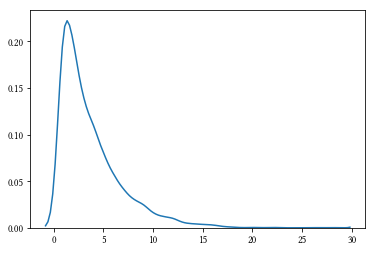

In [11]:
sns.kdeplot([w for u, v, w in G.edges.data('weight')])

In [12]:
min([w for u,v ,w in G.edges.data('weight')])

1

In [13]:
np.mean([w for u,v ,w in G.edges.data('weight')])

3.732243229432805

In [14]:
np.median([w for u,v ,w in G.edges.data('weight')])

3.0

In [15]:
def modularity(G, com):
    e = np.zeros((len(com), len(com)))
    def label(u):
        for i, c in enumerate(com):
            if u in c:
                return i
        return None
    for u, v, w in G.edges.data('weight'): 
        e[label(u), label(v)] += w
    e /= np.sum(e)
    
    return np.trace(e) - np.sum(e * e), e

In [16]:
m, e = modularity(G, communities)

In [17]:
print(m)
e

0.9038474169504862


array([[2.81352683e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.10733844e-04, 0.00000000e+00, 2.05366922e-04, 0.00000000e+00,
        0.00000000e+00, 3.42278204e-04, 5.47645126e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.42278204e-04, 0.00000000e+00, 4.10733844e-04, 0.00000000e+00,
        4.79189485e-04, 2.05366922e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.05366922e-04, 0.00000000e+00, 0.00000000e+00,
        4.10733844e-04],
       [0.00000000e+00, 1.81407448e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.84556407e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.36911281e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00,

In [18]:
mr, er = modularity(G, random_communities)
print(mr)
er

0.0333703510103122


array([[0.0012618 , 0.0012618 , 0.00126998, 0.00126129, 0.00126692,
        0.00125873, 0.00126334, 0.00125618, 0.00125516, 0.00125925,
        0.0012572 , 0.00125822, 0.00126436, 0.00127101, 0.00125618,
        0.00125771, 0.00125516, 0.00125822, 0.00125516, 0.00125822,
        0.00125873, 0.00125873, 0.00125771, 0.00125567, 0.00125822,
        0.00125516, 0.00126589, 0.00126231, 0.00125464],
       [0.00129248, 0.00130373, 0.00129606, 0.00129503, 0.0012935 ,
        0.0012889 , 0.0012889 , 0.00129043, 0.00129146, 0.00128941,
        0.00129197, 0.0012889 , 0.00128685, 0.00128583, 0.00129094,
        0.00129146, 0.00129657, 0.0012889 , 0.00128737, 0.00129094,
        0.00128685, 0.00128992, 0.00128583, 0.00129606, 0.00129452,
        0.00129094, 0.00128941, 0.00128992, 0.00128737],
       [0.00121886, 0.00122704, 0.00122141, 0.00122295, 0.00121835,
        0.00122755, 0.00121374, 0.0012255 , 0.00121783, 0.00121783,
        0.00121783, 0.00121937, 0.00121579, 0.00122346, 0.00121374,
  

Now, the real question: how does $Q$ behave under severe sub-sampling?

In [19]:
def subsample(G, freq=0.01):
    Gp = nx.DiGraph()
    for u, v, d in G.edges.data():
        observed = np.random.binomial(d['weight'], freq)
        if observed > 0:
            Gp.add_edge(u, v, weight=observed)
    return Gp

Lets repeat a few hundred sub-samples and check the distribution of $Q$

In [20]:
def cut_size(G, S, T, weight='weight'):
    edges = nx.edge_boundary(G, S, T, data=weight, default=1)
    return sum(weight for u, v, weight in edges)

In [21]:
def safe_conductance(G, S):
    T = set(G) - set(S)
    return cut_size(G, S, T, weight='weight') / max(1, vol(G,S, weight='weight'))

In [22]:
sample_Qs = []
sample_rand_Qs = []
sample_cond = []
sample_rand_cond = []
for i in range(1000):
    Gp = subsample(G)
    sample_Qs.append(modularity(Gp, communities)[0])
    sample_rand_Qs.append(modularity(Gp, random_communities)[0])
    sample_cond.append([safe_conductance(Gp, com) for com in communities])
    sample_rand_cond.append([safe_conductance(Gp, com) for com in random_communities])

/home/emallson/anaconda3/lib/python3.5/site-packages/matplotlib/backends/backend_pdf.py:1201: UserWarning: 'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


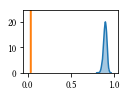

In [23]:
fig, ax = plt.subplots(figsize=(1.7, 1.15))
sns.distplot(sample_Qs, ax=ax)
sns.distplot(sample_rand_Qs, ax=ax)
#ax.axvline(np.mean(sample_Qs), c='k')
ax.set_xlim([-.05,1.05])
plt.savefig('figs/modularity/modularity_normal-mode.pdf', bbox_inches='tight')
plt.show()

/home/emallson/anaconda3/lib/python3.5/site-packages/matplotlib/backends/backend_pdf.py:1201: UserWarning: 'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


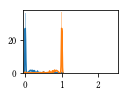

In [24]:
fig, ax = plt.subplots(figsize=(1.7, 1.15))
sns.distplot(np.reshape(sample_cond, (-1,)), ax=ax)
sns.distplot(np.reshape(sample_rand_cond, (-1,)), ax=ax)
#ax.axvline(np.mean(sample_cond), c='k')
ax.set_xlim([-.05,2.55])
plt.savefig('figs/modularity/conductance_normal-mode.pdf', bbox_inches='tight')
plt.show()

In [25]:
np.mean(sample_cond, axis=0).shape

(29,)

In [26]:
sample_cond[1][0]

0.14285714285714285

In [27]:
np.reshape(sample_cond, (-1,))[:24]

array([0.        , 0.        , 0.5       , 0.25      , 0.2       ,
       0.        , 0.        , 0.        , 0.5       , 0.33333333,
       0.07692308, 0.125     , 0.        , 0.        , 0.        ,
       0.33333333, 0.        , 0.        , 0.        , 0.        ,
       0.16666667, 0.        , 0.        , 0.        ])

/home/emallson/anaconda3/lib/python3.5/site-packages/matplotlib/backends/backend_pdf.py:1201: UserWarning: 'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


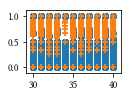

In [28]:
fig, ax = plt.subplots(figsize=(1.7,1.15))
plt.scatter([len(s) for s in communities] * 1000, np.reshape(sample_cond, (-1,)), marker='o')
plt.scatter([len(s) for s in random_communities] * 1000, np.reshape(sample_rand_cond, (-1,)), marker='+')
plt.savefig('figs/modularity/conductance_scatter.pdf', bbox_inches='tight')
plt.show()

In [29]:
def imr(G, com, split=False):
    # returns the imr of an *individual* community
    numer = 0
    denom = 0
    for u in com:
        if u not in G:
            continue
        for u, v, w in G.out_edges(u, data='weight'):
            if v in com:
                numer += w
            denom += w
    if denom == 0:
        return 0
    if split:
        return numer/denom, numer, denom
    return numer / denom

In [30]:
sample_imrs = []
sample_rand_imrs = []
for i in range(1000):
    Gp = subsample(G)
    sample_imrs.append([imr(Gp, com) for com in communities])
    sample_rand_imrs.append([imr(Gp, com) for com in random_communities])

/home/emallson/anaconda3/lib/python3.5/site-packages/matplotlib/backends/backend_pdf.py:1201: UserWarning: 'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


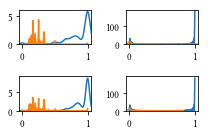

In [31]:
fig, axs = plt.subplots(2,2, figsize=(3,2))
sns.kdeplot([imr[0] for imr in sample_imrs], ax=axs[0,0])
sns.kdeplot([imr[1] for imr in sample_imrs], ax=axs[0,1])
sns.kdeplot([imr[2] for imr in sample_imrs], ax=axs[1,0])
sns.kdeplot([imr[3] for imr in sample_imrs], ax=axs[1,1])

sns.kdeplot([imr[0] for imr in sample_rand_imrs], ax=axs[0,0])
sns.kdeplot([imr[1] for imr in sample_rand_imrs], ax=axs[0,1])
sns.kdeplot([imr[2] for imr in sample_rand_imrs], ax=axs[1,0])
sns.kdeplot([imr[3] for imr in sample_rand_imrs], ax=axs[1,1])

#axs[0,0].axvline(imr(G, list(communities)[0]))
#axs[0,1].axvline(imr(G, list(communities)[1]))
#axs[1,0].axvline(imr(G, list(communities)[2]))
#axs[1,1].axvline(imr(G, list(communities)[3]))
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim([-.05,1.05])

plt.tight_layout()
plt.savefig('figs/modularity/imr_2x2.pdf', bbox_inches='tight')
plt.show()

In [32]:
sample_cond = []
sample_rand_cond = []
for i in range(1000):
    Gp = subsample(G)
    sample_cond.append([safe_conductance(Gp, com) for com in communities])
    sample_rand_cond.append([safe_conductance(Gp, com) for com in random_communities])

/home/emallson/anaconda3/lib/python3.5/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])
/home/emallson/anaconda3/lib/python3.5/site-packages/matplotlib/backends/backend_pdf.py:1201: UserWarning: 'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


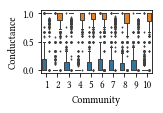

In [33]:
import pandas as pd

true_entries = [{'kind': 'true', 'community': c, 'sample': s, 'conductance': sample_cond[s][c]} for c in range(len(communities)) for s in range(len(sample_cond))]
rand_entries = [{'kind': 'random', 'community': c, 'sample': s, 'conductance': sample_rand_cond[s][c]} for c in range(len(communities)) for s in range(len(sample_rand_cond))]

df = pd.DataFrame(true_entries + rand_entries)

fig, ax = plt.subplots(figsize=(2, 1.15))
sns.boxplot(data=df[df['community'] <= 9], x='community', y='conductance', hue='kind', ax=ax, fliersize=1, linewidth=1)
ax.legend().set_visible(False)
plt.ylabel("Conductance")
plt.xlabel("Community")
ax.set_xticklabels(np.arange(1,11))
plt.savefig('figs/modularity/conductance_boxplot.pdf', bbox_inches='tight')

In [34]:
sample_replaced_33 = []
sample_replaced_66 = []
sample_replaced_100 = []
for i in range(1000):
    Gp = subsample(G)
    sample_replaced_33.append([safe_conductance(Gp, replace_random(G, c, ceil(len(c) / 3))) for c in communities])
    sample_replaced_66.append([safe_conductance(Gp, replace_random(G, c, ceil(2 * len(c) / 3))) for c in communities])
    sample_replaced_100.append([safe_conductance(Gp, replace_random(G, c, len(c))) for c in communities])

NameError: name 'replace_random' is not defined

In [ ]:
replaced33_entries = [{'kind': 'replaced33', 'community': c, 'sample': s, 'conductance': sample_replaced_33[s][c]} for c in range(len(communities)) for s in range(len(sample_replaced_33))]
replaced66_entries = [{'kind': 'replaced66', 'community': c, 'sample': s, 'conductance': sample_replaced_66[s][c]} for c in range(len(communities)) for s in range(len(sample_replaced_66))]
replaced100_entries = [{'kind': 'replaced100', 'community': c, 'sample': s, 'conductance': sample_replaced_100[s][c]} for c in range(len(communities)) for s in range(len(sample_replaced_100))]

In [ ]:
df = pd.DataFrame(true_entries + replaced33_entries + replaced66_entries + replaced100_entries)

fig, ax = plt.subplots(figsize=(3.4, 1.15))
sns.boxplot(data=df[df['community'] <= 7], x='community', y='conductance', hue='kind', ax=ax, fliersize=1, linewidth=1, hue_order=['true', 'replaced33', 'replaced66', 'replaced100'], whis=[5,95], dodge=True)
ax.legend().set_visible(False)
plt.ylabel("Conductance")
plt.xlabel("Community")
ax.set_xticklabels(np.arange(1,11))
plt.savefig('figs/modularity/conductance_boxplot_extended.pdf', bbox_inches='tight')

In [ ]:
df[df['kind'] == 'replaced33'].groupby('community').quantile(.75)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(3,2))
sns.distplot([imr[0] for imr in sample_cond], ax=axs[0,0])
sns.distplot([imr[1] for imr in sample_cond], ax=axs[0,1])
sns.distplot([imr[2] for imr in sample_cond], ax=axs[1,0])
sns.distplot([imr[3] for imr in sample_cond], ax=axs[1,1])

sns.distplot([imr[0] for imr in sample_rand_cond], ax=axs[0,0])
sns.distplot([imr[1] for imr in sample_rand_cond], ax=axs[0,1])
sns.distplot([imr[2] for imr in sample_rand_cond], ax=axs[1,0])
sns.distplot([imr[3] for imr in sample_rand_cond], ax=axs[1,1])

#axs[0,0].axvline(imr(G, list(communities)[0]))
#axs[0,1].axvline(imr(G, list(communities)[1]))
#axs[1,0].axvline(imr(G, list(communities)[2]))
#axs[1,1].axvline(imr(G, list(communities)[3]))
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim([-.05,2.55])

plt.tight_layout()
plt.savefig('figs/modularity/conductance_2x2.pdf', bbox_inches='tight')
plt.show()

What if you do a "One-vs-All" setup with $Q$? (which is what I actually need, because I'm only trying to assign in/out not each community) 

In [ ]:
def modularity_ova(G, com, idx):
    e = np.zeros((2,2))
    def label(u):
        if u in com[idx]:
            return 0
        else:
            return 1
    for u, v, w in G.edges.data('weight'): 
        e[label(u), label(v)] += w
    e /= np.sum(e)
    
    return np.trace(e) - np.sum(e * e), e

In [ ]:
print(modularity_ova(G, communities, 0)[0])
print(modularity_ova(G, communities, 1)[0])
print(modularity_ova(G, communities, 2)[0])
print(modularity_ova(G, communities, 3)[0])

In [ ]:
sample_ova_Qs = []
sample_ova_rand_Qs = []
for i in range(1000):
    Gp = subsample(G)
    sample_ova_Qs.append([modularity_ova(Gp, communities, i)[0] for i in range(len(communities))])
    sample_ova_rand_Qs.append([modularity_ova(Gp, random_communities, i)[0] for i in range(len(random_communities))])

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(3,2))
sns.distplot([q[0] for q in sample_ova_Qs], ax=axs[0,0])
sns.distplot([q[1] for q in sample_ova_Qs], ax=axs[0,1])
sns.distplot([q[2] for q in sample_ova_Qs], ax=axs[1,0])
sns.distplot([q[3] for q in sample_ova_Qs], ax=axs[1,1])

sns.distplot([q[0] for q in sample_ova_rand_Qs], ax=axs[0,0])
sns.distplot([q[1] for q in sample_ova_rand_Qs], ax=axs[0,1])
sns.distplot([q[2] for q in sample_ova_rand_Qs], ax=axs[1,0])
sns.distplot([q[3] for q in sample_ova_rand_Qs], ax=axs[1,1])

#axs[0,0].axvline(modularity_ova(G, communities, 0)[0])
#axs[0,1].axvline(modularity_ova(G, communities, 1)[0])
#axs[1,0].axvline(modularity_ova(G, communities, 2)[0])
#axs[1,1].axvline(modularity_ova(G, communities, 3)[0])
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim([-.05,1.05])
        

plt.tight_layout()
plt.savefig('figs/modularity/q-ova_2x2.pdf', bbox_inches='tight')
plt.show()

How many edges are preserved by the subsampling?

In [ ]:
sample_edges = []
sample_nodes = []
for i in range(1000):
    Gp = subsample(G)
    sample_edges.append(len(Gp.edges) / len(G.edges))
    sample_nodes.append(len(Gp.nodes) / len(G.nodes))
print(np.mean(sample_nodes))
print(np.mean(sample_edges))

What if we are partly wrong about community structure? Lets plot IMR as a function of the % of the community that is random, and vs % of the community that is *missing*.

In [ ]:
def replace_random(G, c, count, seed=None):
    from numpy.random import RandomState
    rs = RandomState(seed)
    remove = rs.choice(list(c), count, replace=False)
    replace = rs.choice([u for u in G.nodes if u not in c or u in remove], count, replace=False)
    assert(not any((u in c and u not in remove) for u in replace))
    return list(set(u for u in c if u not in remove) | set(replace))

In [ ]:
def remove_random(c, count, seed=None):
    from numpy.random import RandomState
    rs = RandomState(seed)
    remove = rs.choice(list(c), count, replace=False)
    return [u for u in c if u not in remove]

In [ ]:
Gp = subsample(G)

c = communities[0]

samples = 1000
rep_comp = np.zeros((samples, len(c)))
rep_sub = np.zeros((samples, len(c)))
rem_comp = np.zeros((samples, len(c)))
rem_sub = np.zeros((samples, len(c)))
for i in range(samples):
    for j in range(len(c)):
        rep_comp[i, j] = safe_conductance(G, replace_random(G, c, j))
        rep_sub[i, j] = safe_conductance(Gp, replace_random(Gp, c, j))
        rem_comp[i, j] = safe_conductance(G, remove_random(c, j))
        rem_sub[i, j] = safe_conductance(Gp, remove_random(c, j))

In [ ]:
from scipy.stats import t
fig, ax = plt.subplots(figsize=(3,2))

plt.plot(np.arange(len(c)) / len(c), np.mean(rep_comp, axis=0), label='Replace, $G$', c='tab:blue')
below, above = t.interval(0.95, samples-1, loc=np.mean(rep_comp, axis=0), scale=np.std(rep_comp, axis=0))
plt.fill_between(np.arange(len(c)) / len(c), below, above, color='tab:blue', alpha=0.2)

plt.plot(np.arange(len(c)) / len(c), np.mean(rem_comp, axis=0), label='Remove, $G$', c='tab:red')
below, above = t.interval(0.95, samples-1, loc=np.mean(rem_comp, axis=0), scale=np.std(rem_comp, axis=0))
plt.fill_between(np.arange(len(c)) / len(c), below, above, color='tab:red', alpha=0.2)


plt.plot(np.arange(len(c)) / len(c), np.mean(rep_sub, axis=0), label="Replace, $G'$", c='tab:green')
below, above = t.interval(0.95, samples-1, loc=np.mean(rep_sub, axis=0), scale=np.std(rep_sub, axis=0))
plt.fill_between(np.arange(len(c)) / len(c), below, above, color='tab:green', alpha=0.2)

plt.plot(np.arange(len(c)) / len(c), np.mean(rem_sub, axis=0), label="Remove, $G'$", c='tab:orange')
below, above = t.interval(0.95, samples-1, loc=np.mean(rem_sub, axis=0), scale=np.std(rem_sub, axis=0))
plt.fill_between(np.arange(len(c)) / len(c), below, above, color='tab:orange', alpha=0.1)

plt.legend(ncol=2, columnspacing=1, labelspacing=0, handlelength=1, bbox_to_anchor=(1,.345,0,0))
plt.savefig('figs/modularity/robustness-imr.pdf', bbox_inches='tight')
plt.show()

In [ ]:
def modularity_ova2(G, com):
    e = np.zeros((2,2))
    def label(u):
        if u in com:
            return 0
        else:
            return 1
    for u, v, w in G.edges.data('weight'): 
        e[label(u), label(v)] += w
    e /= np.sum(e)
    
    return np.trace(e) - np.sum(e * e), e

In [ ]:
Gp = subsample(G)

c = communities[0]

samples = 1000
rep_comp = np.zeros((samples, len(c)))
rep_sub = np.zeros((samples, len(c)))
rem_comp = np.zeros((samples, len(c)))
rem_sub = np.zeros((samples, len(c)))
for i in range(samples):
    for j in range(len(c)):
        rep_comp[i, j] = modularity_ova2(G, replace_random(G, c, j))[0]
        rep_sub[i, j] = modularity_ova2(Gp, replace_random(Gp, c, j))[0]
        rem_comp[i, j] = modularity_ova2(G, remove_random(c, j))[0]
        rem_sub[i, j] = modularity_ova2(Gp, remove_random(c, j))[0]

In [ ]:
from scipy.stats import t
fig, ax = plt.subplots(figsize=(3,2))

plt.plot(np.arange(len(c)) / len(c), np.mean(rep_comp, axis=0), label='Replace, $G$', c='tab:blue')
below, above = t.interval(0.95, samples-1, loc=np.mean(rep_comp, axis=0), scale=np.std(rep_comp, axis=0))
plt.fill_between(np.arange(len(c)) / len(c), below, above, color='tab:blue', alpha=0.2)

plt.plot(np.arange(len(c)) / len(c), np.mean(rem_comp, axis=0), label='Remove, $G$', c='tab:red')
below, above = t.interval(0.95, samples-1, loc=np.mean(rem_comp, axis=0), scale=np.std(rem_comp, axis=0))
plt.fill_between(np.arange(len(c)) / len(c), below, above, color='tab:red', alpha=0.2)


plt.plot(np.arange(len(c)) / len(c), np.mean(rep_sub, axis=0), label="Replace, $G'$", c='tab:green')
below, above = t.interval(0.95, samples-1, loc=np.mean(rep_sub, axis=0), scale=np.std(rep_sub, axis=0))
plt.fill_between(np.arange(len(c)) / len(c), below, above, color='tab:green', alpha=0.2)

plt.plot(np.arange(len(c)) / len(c), np.mean(rem_sub, axis=0), label="Remove, $G'$", c='tab:orange')
below, above = t.interval(0.95, samples-1, loc=np.mean(rem_sub, axis=0), scale=np.std(rem_sub, axis=0))
plt.fill_between(np.arange(len(c)) / len(c), below, above, color='tab:orange', alpha=0.1)

plt.legend(ncol=2, columnspacing=1, labelspacing=0, handlelength=1, loc='upper center')
plt.ylim([0,0.5])
plt.savefig('figs/modularity/robustness-modularity.pdf', bbox_inches='tight')
plt.show()